In [1]:
import re
import shap
import japanize_matplotlib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
sns.set(font="IPAexGothic")
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import RANSACRegressor

from glob import glob
from functools import partial
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from xfeat import SelectCategorical, LabelEncoder, LambdaEncoder, Pipeline, ConcatCombination, SelectNumerical, \
ArithmeticCombinations, TargetEncoder, aggregation, GBDTFeatureSelector, GBDTFeatureExplorer

shap.initjs()

In [3]:
train = pd.read_csv('output.csv')

Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.


In [4]:
test = pd.read_csv('./data/test.csv')


In [7]:
ID = 'ID'
TARGET = '取引価格（総額）_log'
rm_cols = []

df = pd.concat([train, test])
rm_cols += ['市区町村コード']
for i, v in df.nunique().iteritems():
    if v <= 1:
        rm_cols.append(i)

rm_cols

['市区町村コード',
 '種類',
 '地域',
 '土地の形状',
 '間口',
 '延床面積（㎡）',
 '前面道路：方位',
 '前面道路：種類',
 '前面道路：幅員（ｍ）']

In [9]:
def normalize_moyori(moyori):
    if moyori == moyori:
        if moyori == '30分?60分':
            moyori = 45
        elif moyori == '1H?1H30':
            moyori = 75
        elif moyori == '1H30?2H':
            moyori = 105
        elif moyori == '2H?':
            moyori = 120
        moyori = int(moyori)
    return moyori

In [10]:
def normalize_area(area):
    if area == area:
        area = int(re.sub('m\^2未満|㎡以上', '', str(area)))
    return area

In [11]:
def convert_wareki_to_seireki(wareki):
    if wareki == wareki:
        if wareki == '戦前':
            wareki = '昭和20年'
        value = wareki[2:-1]
        if value == '元':
            value = 1
        else:
            value = int(value)
        if '昭和' in wareki:
            seireki = 1925+value
        elif '平成' in wareki:
            seireki = 1988+value
        elif '令和' in wareki:
            seireki = 2018+value
    else:
        seireki = wareki
    return seireki

In [12]:
test[TARGET] = np.nan
train.drop(rm_cols, axis=1, inplace=True)
test.drop(columns=rm_cols, axis=1, inplace=True)


In [13]:
# df['取引時点_何年前'] = df['取引時点'].apply(lambda x: 2021-int(x[:4]))
df = pd.concat([train, test])
df.sort_values('取引時点', inplace=True)
df.reset_index(drop=True, inplace=True)
df.shape

(700543, 19)

In [14]:
df['取引時点'].unique()

array(['2005年第３四半期', '2005年第４四半期', '2006年第１四半期', '2006年第２四半期',
       '2006年第３四半期', '2006年第４四半期', '2007年第１四半期', '2007年第２四半期',
       '2007年第３四半期', '2007年第４四半期', '2008年第１四半期', '2008年第２四半期',
       '2008年第３四半期', '2008年第４四半期', '2009年第１四半期', '2009年第２四半期',
       '2009年第３四半期', '2009年第４四半期', '2010年第１四半期', '2010年第２四半期',
       '2010年第３四半期', '2010年第４四半期', '2011年第１四半期', '2011年第２四半期',
       '2011年第３四半期', '2011年第４四半期', '2012年第１四半期', '2012年第２四半期',
       '2012年第３四半期', '2012年第４四半期', '2013年第１四半期', '2013年第２四半期',
       '2013年第３四半期', '2013年第４四半期', '2014年第１四半期', '2014年第２四半期',
       '2014年第３四半期', '2014年第４四半期', '2015年第１四半期', '2015年第２四半期',
       '2015年第３四半期', '2015年第４四半期', '2016年第１四半期', '2016年第２四半期',
       '2016年第３四半期', '2016年第４四半期', '2017年第１四半期', '2017年第２四半期',
       '2017年第３四半期', '2017年第４四半期', '2018年第１四半期', '2018年第２四半期',
       '2018年第３四半期', '2018年第４四半期', '2019年第１四半期', '2019年第２四半期',
       '2019年第３四半期', '2019年第４四半期', '2020年第１四半期', '2020年第２四半期',
       '2020年第３四半期', '2020年第４四半期', '2021年第１四半期'], dtype

In [15]:
val_min_idx = min(df[df['取引時点'].str.contains('2020年第２四半期|2020年第３四半期', regex=True)].index)
test_min_idx = min(df[df['取引時点'].str.contains('2020年第４四半期|2021年第１四半期', regex=True)].index)
val_min_idx, test_min_idx

(652493, 677392)

In [16]:
set(df.iloc[val_min_idx:test_min_idx, :]['取引時点'].values)

{'2020年第２四半期', '2020年第３四半期'}

In [17]:
enc_dic = {}
for i, e in enumerate(sorted(list(set(df['取引時点'].values)))):
    enc_dic[e] = i
df['取引時点_enc'] = df['取引時点'].map(enc_dic)

In [18]:

df['建築年'] = df['建築年'].apply(lambda x: convert_wareki_to_seireki(x))
# df['取引_建築'] = df['取引時点'].apply(lambda x: int(x[:4])) - df['建築年']
df['面積（㎡）'] = df['面積（㎡）'].apply(lambda x: normalize_area(x))
df['最寄駅：距離（分）'] = df['最寄駅：距離（分）'].apply(lambda x: normalize_moyori(x))
df.drop(['取引時点'], axis=1, inplace=True)


In [19]:
# 今後の利用目的と建物の構造を削除
df.drop(['今後の利用目的', '建物の構造'], axis=1, inplace=True)


In [20]:
encoder = Pipeline([
    SelectCategorical(),
    LabelEncoder(output_suffix=""),
])

le_df = encoder.fit_transform(df)
le_df.head(2)

,都道府県名,市区町村名,地区名,最寄駅：名称,間取り,用途,都市計画,改装,取引の事情等
0,0,0,0,0,0,0,-1,-1,-1
1,1,1,1,1,1,0,0,0,-1


In [21]:
num_feature = [x for x in df.columns if df[x].dtype != 'object']
df[num_feature].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700543 entries, 0 to 700542
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   ID            700543 non-null  int64  
 1   最寄駅：距離（分）     677413 non-null  float64
 2   面積（㎡）         700543 non-null  int64  
 3   建築年           680241 non-null  float64
 4   建ぺい率（％）       676793 non-null  float64
 5   容積率（％）        676793 non-null  float64
 6   取引価格（総額）_log  677392 non-null  float64
 7   取引時点_enc      700543 non-null  int64  
dtypes: float64(5), int64(3)
memory usage: 42.8 MB


In [22]:
cat_feature = [x for x in df.columns if df[x].dtype == 'object']
df[cat_feature]

,都道府県名,市区町村名,地区名,最寄駅：名称,間取り,用途,都市計画,改装,取引の事情等
0,神奈川県,横浜市南区,真金町,阪東橋,１Ｋ,住宅,NaN,NaN,NaN
1,東京都,中野区,中央,新中野,１ＬＤＫ,住宅,近隣商業地域,未改装,NaN
2,京都府,京都市伏見区,桃山町丹下,墨染,３ＬＤＫ,住宅,第１種住居地域,未改装,NaN
3,東京都,世田谷区,深沢,都立大学,３ＬＤＫ,住宅,第１種中高層住居専用地域,未改装,NaN
4,埼玉県,さいたま市緑区,原山,浦和,２ＬＤＫ,住宅,NaN,改装済,NaN
...,...,...,...,...,...,...,...,...,...
700538,愛知県,名古屋市千種区,桜が丘,星ケ丘(愛知),３ＬＤＫ,住宅,第１種住居地域,未改装,NaN
700539,東京都,新宿区,中落合,落合南長崎,１Ｋ,NaN,近隣商業地域,未改装,NaN
700540,東京都,新宿区,中落合,落合南長崎,１Ｋ,住宅,近隣商業地域,改装済,NaN
700541,愛知県,名古屋市千種区,末盛通,覚王山,１ＬＤＫ,住宅,商業地域,NaN,NaN


In [23]:
def get_agg_df(df, group_col):

    agg_df, agg_cols = aggregation(df,
                        group_key=group_col,
                        group_values=['最寄駅：距離（分）',
#                                       '面積（㎡）',
#                                       '建ぺい率（％）',
#                                       '容積率（％）'
                                     ],
                        agg_methods=['count', 'mean']
                        )

    return agg_df[agg_cols]

group_col = '市区町村名'
agg_dis_2 = get_agg_df(df, group_col)
group_col1 = '都道府県名'
agg_dis_pre = get_agg_df(df, group_col1)

In [24]:
df.head()

,ID,都道府県名,市区町村名,地区名,最寄駅：名称,最寄駅：距離（分）,間取り,面積（㎡）,建築年,用途,都市計画,建ぺい率（％）,容積率（％）,改装,取引の事情等,取引価格（総額）_log,取引時点_enc
0,14198339,神奈川県,横浜市南区,真金町,阪東橋,NaN,１Ｋ,15,1992.0,住宅,NaN,NaN,NaN,NaN,NaN,6.698970,0
1,13318874,東京都,中野区,中央,新中野,NaN,１ＬＤＫ,40,1999.0,住宅,近隣商業地域,80.0,400.0,未改装,NaN,7.380211,0
2,26081806,京都府,京都市伏見区,桃山町丹下,墨染,4.0,３ＬＤＫ,60,1994.0,住宅,第１種住居地域,60.0,200.0,未改装,NaN,7.176091,0
3,13302280,東京都,世田谷区,深沢,都立大学,NaN,３ＬＤＫ,85,2004.0,住宅,第１種中高層住居専用地域,60.0,200.0,未改装,NaN,7.832509,0
4,11089836,埼玉県,さいたま市緑区,原山,浦和,NaN,２ＬＤＫ,50,1990.0,住宅,NaN,NaN,NaN,改装済,NaN,6.977724,0


In [25]:
feat_df = pd.concat([df[num_feature], le_df, agg_dis_2, agg_dis_pre], axis=1)

In [26]:
feat_df.head()

,ID,最寄駅：距離（分）,面積（㎡）,建築年,建ぺい率（％）,容積率（％）,取引価格（総額）_log,取引時点_enc,都道府県名,市区町村名,...,最寄駅：名称,間取り,用途,都市計画,改装,取引の事情等,agg_count_最寄駅：距離（分）_grpby_市区町村名,agg_mean_最寄駅：距離（分）_grpby_市区町村名,agg_count_最寄駅：距離（分）_grpby_都道府県名,agg_mean_最寄駅：距離（分）_grpby_都道府県名
0,14198339,NaN,15,1992.0,NaN,NaN,6.698970,0,0,0,...,0,0,0,-1,-1,-1,3694,8.494857,95841,13.536514
1,13318874,NaN,40,1999.0,80.0,400.0,7.380211,0,1,1,...,1,1,0,0,0,-1,4524,6.402078,201943,7.800889
2,26081806,4.0,60,1994.0,60.0,200.0,7.176091,0,2,2,...,2,2,0,1,0,-1,1908,9.590147,15959,10.065982
3,13302280,NaN,85,2004.0,60.0,200.0,7.832509,0,1,3,...,3,2,0,2,0,-1,11256,8.792822,201943,7.800889
4,11089836,NaN,50,1990.0,NaN,NaN,6.977724,0,3,4,...,4,3,0,-1,1,-1,548,19.826642,41539,13.331857


In [27]:
feat_df['距離_bin'] = pd.cut(feat_df['最寄駅：距離（分）'], [0, 30, 45, 75, 120], labels=False)

In [28]:
nulti = feat_df['面積（㎡）'] * feat_df['容積率（％）']
feat_df['容積_面積'] = nulti

In [29]:
feat_df.head()

,ID,最寄駅：距離（分）,面積（㎡）,建築年,建ぺい率（％）,容積率（％）,取引価格（総額）_log,取引時点_enc,都道府県名,市区町村名,...,用途,都市計画,改装,取引の事情等,agg_count_最寄駅：距離（分）_grpby_市区町村名,agg_mean_最寄駅：距離（分）_grpby_市区町村名,agg_count_最寄駅：距離（分）_grpby_都道府県名,agg_mean_最寄駅：距離（分）_grpby_都道府県名,距離_bin,容積_面積
0,14198339,NaN,15,1992.0,NaN,NaN,6.698970,0,0,0,...,0,-1,-1,-1,3694,8.494857,95841,13.536514,NaN,NaN
1,13318874,NaN,40,1999.0,80.0,400.0,7.380211,0,1,1,...,0,0,0,-1,4524,6.402078,201943,7.800889,NaN,16000.0
2,26081806,4.0,60,1994.0,60.0,200.0,7.176091,0,2,2,...,0,1,0,-1,1908,9.590147,15959,10.065982,0.0,12000.0
3,13302280,NaN,85,2004.0,60.0,200.0,7.832509,0,1,3,...,0,2,0,-1,11256,8.792822,201943,7.800889,NaN,17000.0
4,11089836,NaN,50,1990.0,NaN,NaN,6.977724,0,3,4,...,0,-1,1,-1,548,19.826642,41539,13.331857,NaN,NaN


In [30]:
feat_df['距離'] = feat_df['agg_count_最寄駅：距離（分）_grpby_都道府県名'] / (feat_df['agg_count_最寄駅：距離（分）_grpby_市区町村名']+1)

In [31]:
train_df = feat_df.iloc[:val_min_idx, :]
val_df = feat_df.iloc[val_min_idx:test_min_idx, :]
test_df = feat_df.iloc[test_min_idx:, :]
print(train_df.shape, val_df.shape, test_df.shape)

(652493, 24) (24899, 24) (23151, 24)


In [32]:
feat_cols = [col for col in train_df.columns if col not in rm_cols+[ID, TARGET]]

In [33]:
train_x = train_df[feat_cols]
train_y = train_df[TARGET]
val_x = val_df[feat_cols]
val_y = val_df[TARGET]
test_x = test_df[feat_cols]
test_y = test_df[TARGET]

<AxesSubplot:>

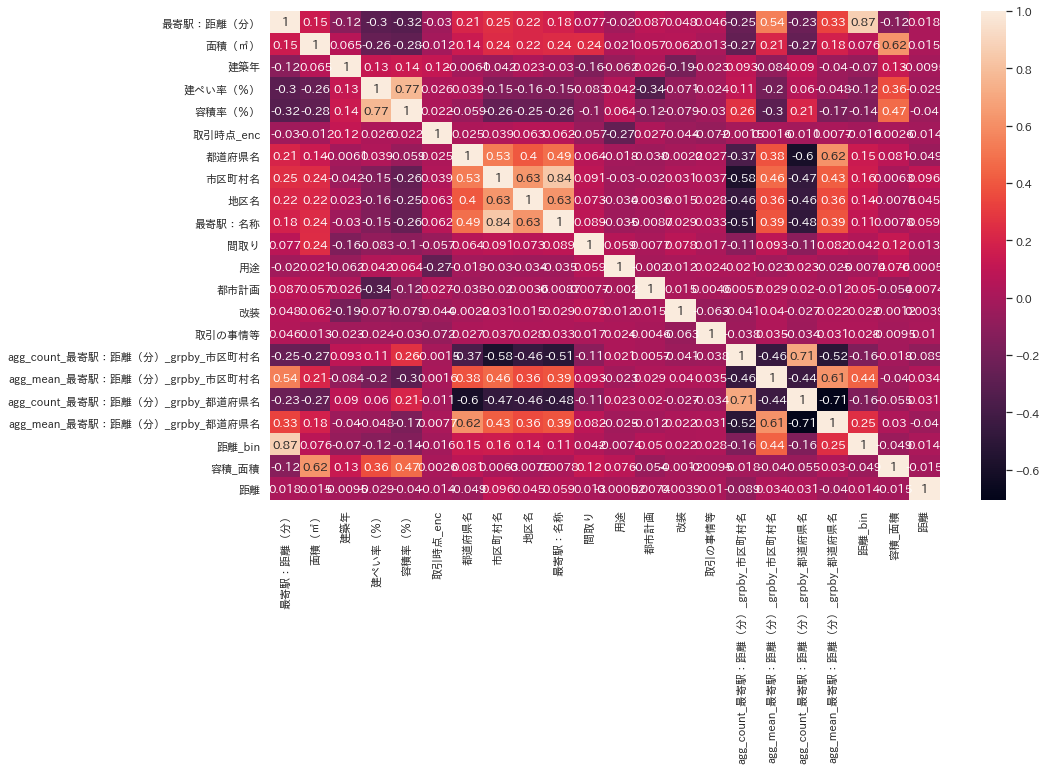

In [35]:
fig = plt.figure(figsize=(15,9))
sns.heatmap(train_x.corr(), annot=True)

In [36]:
cat_cols = list(le_df.columns) + ['取引時点_enc']
cat_cols

['都道府県名',
 '市区町村名',
 '地区名',
 '最寄駅：名称',
 '間取り',
 '用途',
 '都市計画',
 '改装',
 '取引の事情等',
 '取引時点_enc']

In [37]:
SEED = 0

params = {
    'objective':'regression',
    'metric':'mae',
    'num_boost_round':50000,
    'early_stopping_rounds':100,
    'random_state':0,
    'learning_rate':0.03
}

In [38]:
train_data = lgb.Dataset(train_x, label=train_y)
val_data = lgb.Dataset(val_x, label=val_y)

model = lgb.train(
    params,
    train_data, 
#     categorical_feature = cat_cols,
    valid_names = ['train', 'valid'],
    valid_sets =[train_data, val_data], 
    verbose_eval = 100,
)

val_pred = model.predict(val_x, num_iteration=model.best_iteration)
score = mean_absolute_error(val_y, val_pred)

pred_df = pd.DataFrame(sorted(zip(val_x.index, val_pred, val_y)), columns=['index', 'predict', 'actual'])

feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(), train_x.columns)), columns=['importance', 'feature'])

print(f'score: {score:.4f}')

Found `num_boost_round` in params. Will use it instead of argument
Found `early_stopping_rounds` in params. Will use it instead of argument


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036725 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2202
[LightGBM] [Info] Number of data points in the train set: 652493, number of used features: 22
[LightGBM] [Info] Start training from score 7.219515
Training until validation scores don't improve for 100 rounds
[100]	train's l1: 0.115126	valid's l1: 0.124524
[200]	train's l1: 0.102449	valid's l1: 0.107664
[300]	train's l1: 0.096902	valid's l1: 0.101397
[400]	train's l1: 0.0937103	valid's l1: 0.0978453
[500]	train's l1: 0.0918189	valid's l1: 0.0957725
[600]	train's l1: 0.0903672	valid's l1: 0.0941336
[700]	train's l1: 0.089231	valid's l1: 0.0930311
[800]	train's l1: 0.0882723	valid's l1: 0.0920717
[900]	train's l1: 0.0875372	valid's l1: 0.0912365
[1000]	train's l1: 0.0868076	valid's l1: 0.0905327
[1100]	train's l1: 0.0861058	valid

In [40]:
explainer = shap.TreeExplainer(model, data=train_x[:1000])

In [41]:
train_x_shap_values = explainer.shap_values(train_x[:1000])

100%|===================| 999/1000 [02:44<00:00]        

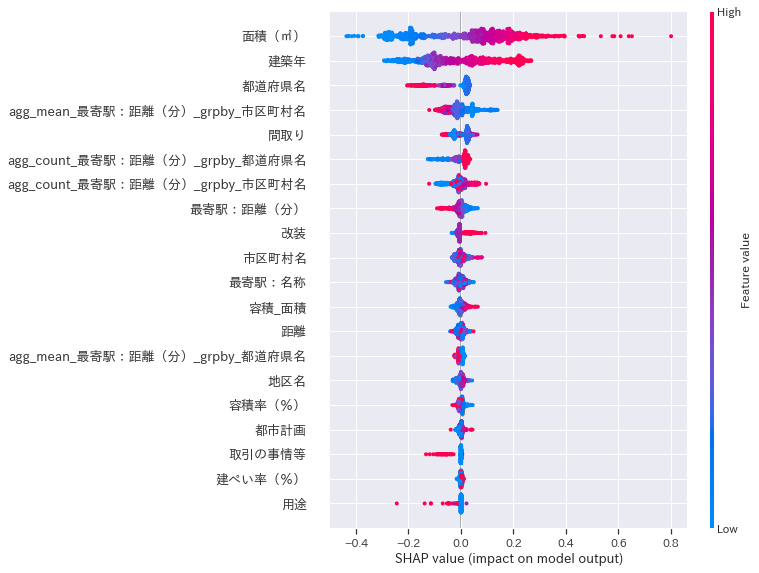

In [44]:
shap.summary_plot(shap_values=train_x_shap_values,
                  features=train_x[:1000],
                  feature_names=train_x.columns)

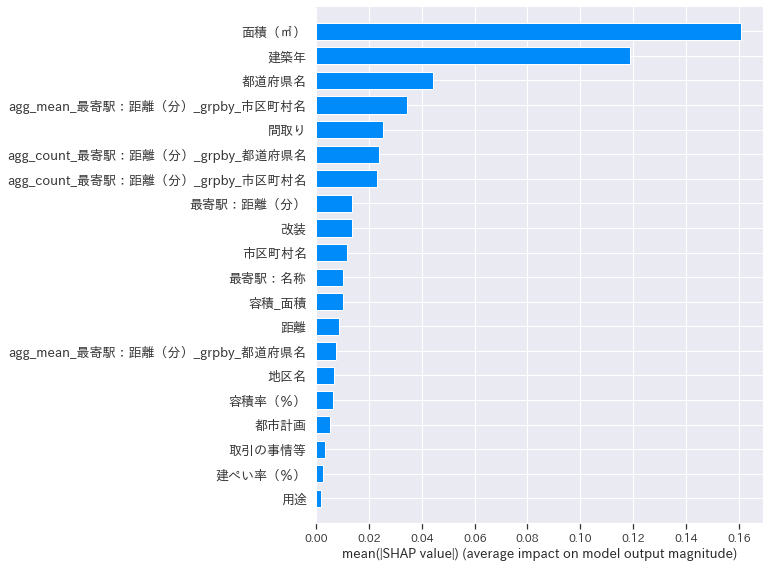

In [45]:
shap.summary_plot(shap_values=train_x_shap_values,
                  features=train_x[:1000],
                  feature_names=train_x.columns,
                  plot_type='bar')

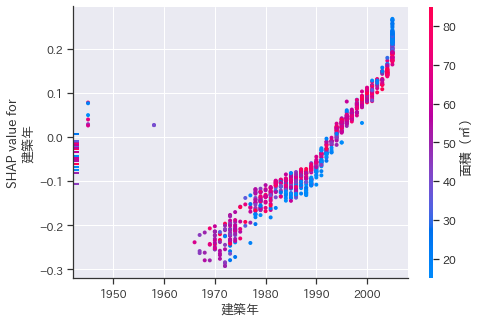

In [46]:
shap.dependence_plot(ind='建築年',
                     interaction_index='面積（㎡）',
                     shap_values=train_x_shap_values,
                     features=train_x[:1000],
                     feature_names = train_x.columns)

In [48]:
shap.force_plot(base_value=explainer.expected_value,
                shap_values=train_x_shap_values,
                features=train_x[:1000],
                feature_names=train_x.columns)

In [53]:
shap.force_plot(base_value=explainer.expected_value,
                shap_values=train_x_shap_values[0],
                features=train_x.iloc[0],
                feature_names=train_x.columns,
                figsize=(25,6))

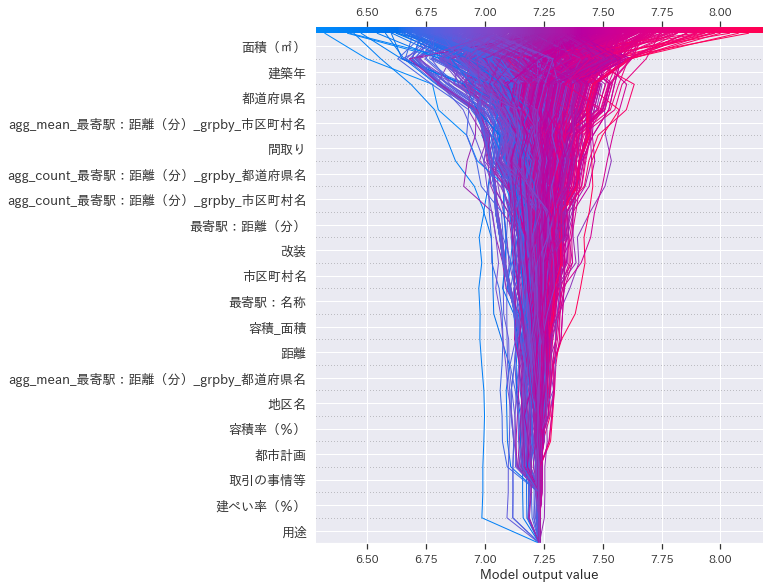

In [50]:
shap.decision_plot(base_value=explainer.expected_value,
                   shap_values=train_x_shap_values,
                   features=train_x[:1000],
                   feature_names=list(train_x.columns))

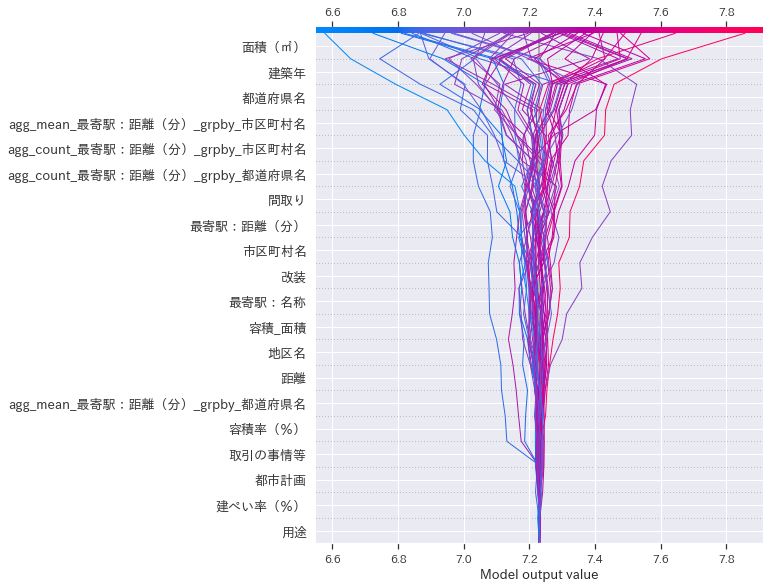

In [54]:
shap.decision_plot(base_value=explainer.expected_value,
                   shap_values=train_x_shap_values[:50],
                   features=train_x.iloc[:50],
                   feature_names=list(train_x.columns))

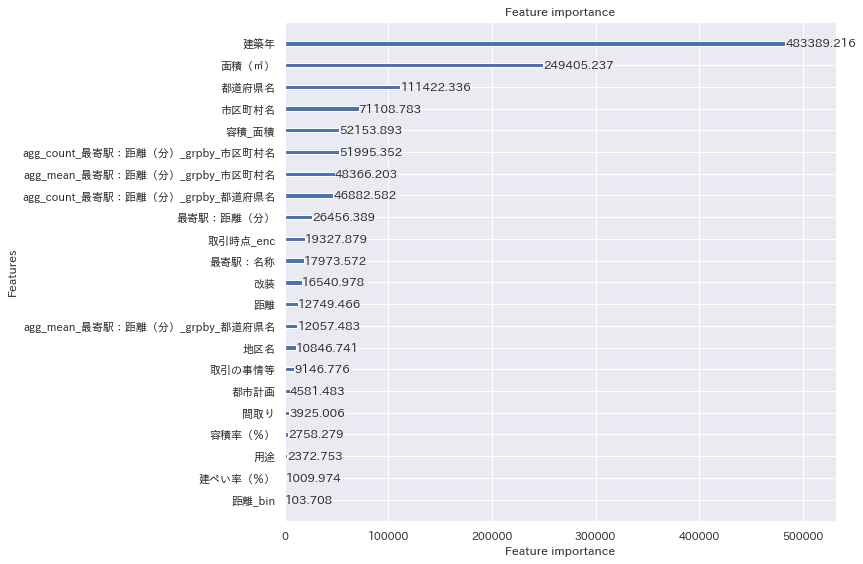

In [52]:
lgb.plot_importance(model, figsize=(12,8), max_num_features=50, importance_type='gain')
plt.tight_layout()
# plt.savefig(BASE_PATH + 'output/feature_importance.png')
plt.show()
plt.close()